# Plots of observed MF and performing AM

In [1]:
# Load some modules
import numpy as np
import matplotlib.pyplot as plt
import AbundanceMatching as amatch
from astropy import constants as const, units as u
from cosmolopy import density

**Questions:**
- What is the masknan?

**TO DO:**
- add error bars to MF plot

## Mass functions:

In [2]:
# Load precomputed differential mass functions
SMF = np.loadtxt("../BAM/SMF_bin_abundance.dat")
BMF = np.loadtxt("../BAM/BMF_bin_abundance.dat")
HIMF = np.loadtxt("../BAM/HIMF_bin_abundance.dat")

SMF_ids = np.where(SMF[:, 0] >= 6.8)
BMF_ids = np.where(BMF[:, 0] >= 6.8)
HIMF_ids = np.where(HIMF[:, 0] >= 6.8)

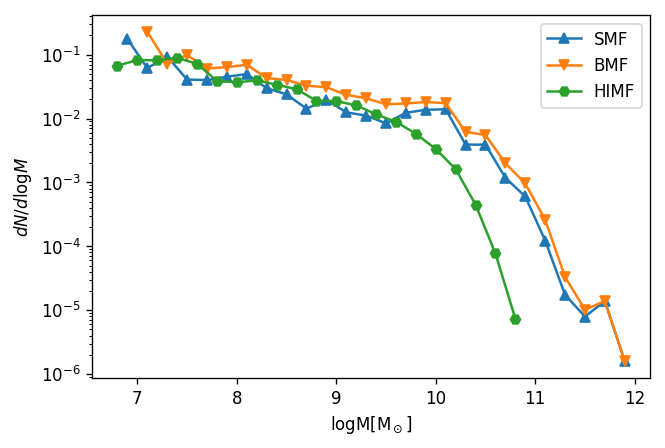

In [3]:
# Plot the mass functions to have a look
plt.figure(dpi=120)
plt.semilogy(SMF[:, 0][SMF_ids], SMF[:, 1][SMF_ids], label='SMF', marker='^')
plt.semilogy(BMF[:, 0][BMF_ids], BMF[:, 1][BMF_ids], label='BMF', marker='v')
plt.semilogy(HIMF[:, 0][HIMF_ids], HIMF[:, 1][HIMF_ids], label='HIMF', marker='H')
plt.xlabel(r'$\log\mathrm{M}[\mathrm{M}_\odot]$')
plt.ylabel(r'${d N}/{d\log M}$')
plt.legend()
plt.show()

## Abundance matching:

In [4]:
def vvir_from_cosmology(halos, cosmology):
    """
    Computes the peak virial velocity from cosmology, to be used in computing the halo proxy.
    """
    z_mpeak = (1.0-halos['mpeak_scale'])/halos['mpeak_scale']
    OmegaM_mpeak = density.omega_M_z(z_mpeak, **cosmology)
    Delta_vir = (18.0*np.pi**2+82*(OmegaM_mpeak-1.0)-39.0*(OmegaM_mpeak-1.0)**2)/OmegaM_mpeak
    rho_crit, rho_mean = density.cosmo_densities(**cosmology)*u.Msun/(u.Mpc**3)
    Rvir_mpeak = (3.0*halos['mpeak']*u.Msun/(4.0*np.pi*rho_crit*Delta_vir))**(1.0/3.0)
    vvir_mpeak = np.sqrt(const.G*halos['mpeak']*u.astrophys.solMass/Rvir_mpeak).to(u.km/u.s)
    return vvir_mpeak.value

### Choose parameters for AF and cosmology

In [5]:
# Halo proxy
alpha = 0.
# Cosmological parameters
cosmology = {u'h': 0.688, u'omega_lambda_0': 0.705, u'omega_k_0': 0.0, u'omega_M_0': 0.295}
# Size of simulation box size
box_size = 400.0 #in Mpc

### Load halos, pick observational mass function, name some halos parameters

In [6]:
# Halos list from N-body
halos = np.load("../BAM/hlist_1.00000.npy")
# Mass function (was loaded into memory previously)
mf_name = 'SMF'
mf = SMF
vvir = vvir_from_cosmology(halos, cosmology)
vmax = halos['Vmax@Mpeak']
mvir = halos['mvir']/0.688 # Put virial mass into physical Msun units
conc = halos['rvir']/halos['rs_klypin']

### Setup the abundance matching

In [7]:
# Abundances are not logged, masses are logged
af =  amatch.AbundanceFunction(mf[:,0], mf[:,1], (5., 13.), faint_end_first=True)
# Halo matching proxy parameter
plist = vvir*(vmax/vvir)**alpha

# Calculate the number densities for the halo proxy parameter
nd_halos = amatch.calc_number_densities(plist, box_size)
# Do abundance matching, match the number densities. Here 0 scatter
catalog = af.match(nd_halos)

### Abundance matching deconvolution to create catalogs

In [8]:
Niter = 1
# Do the deconvolution a number of times for different values of scatter.
# For each iteration number prints the catalog length and how many nans are in it.
for i in range(Niter):
    scatter = 0.16
    # Deconvolute the abundance function with a given scatter (assuming Gaussian)
    af.deconvolute(scatter, repeat=20)
    catalog_16 = af.match(nd_halos, scatter)
    
    scatter = 0.4
    af.deconvolute(scatter, repeat=50)
    catalog_40 = af.match(nd_halos, scatter)
    
    mask = (~np.isnan(catalog)) & (catalog>7.)
    catalog_final = np.transpose(np.array([mvir[mask], conc[mask], catalog[mask],
                                           catalog_16[mask], catalog_40[mask]]))
    
    masknan = np.isnan(catalog_final)
    print i, len(catalog_final), len(catalog_final[masknan])
    np.save('../Catalog_Baryon/Catalog_'+ str(mf_name) + '_Iter'
            +str(i)+'_Alpha' +str(alpha).replace('.', ',')+'.npy', catalog_final)
    
    

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


0 6421618 0
